# DZ Обучение сверточной сети на практике

## CNN for Cat & Doc img recognition

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import vgg16

In [2]:
import os
from random import shuffle
from glob import glob

In [3]:
# Input data - image
IMG_SIZE = (100, 100)  # let's try to difine input img size

train_files = glob('dogs-vs-cats-redux-kernels-edition/train/*.jpg')
test_files = glob('dogs-vs-cats-redux-kernels-edition/test/*.jpg')


In [4]:
# Functions

# load and preprocesing (for vgg16) input img
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  

# Generator for tran data (source local disk)
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# Generator for test data (source local disk)
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

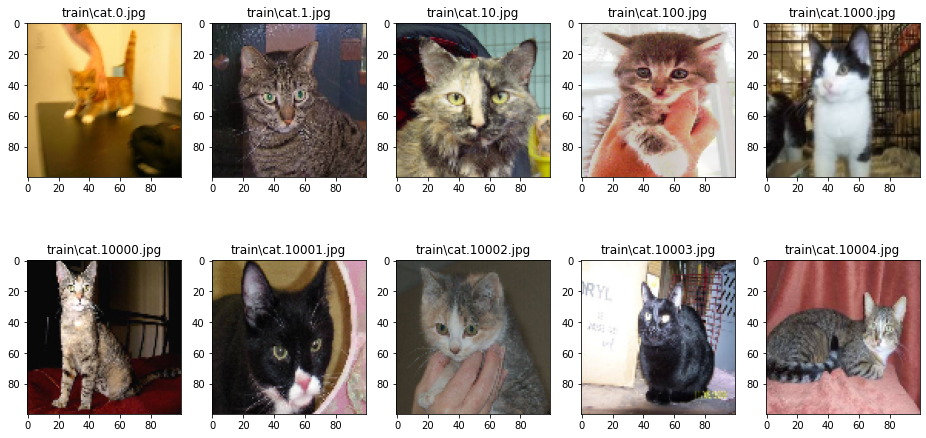

In [12]:
# Visualization of input data
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)


In [13]:
# Upload alredy trained data
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 35s 1us/step


In [14]:
# Architecture of model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [15]:
# Modification of network by dense layer as last layer

# weigth of pre-trained network
for layer in base_model.layers:
    layer.trainable = False

#      Adding dense layer after 5thlayer
x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0
                          activation='sigmoid',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [17]:
# Model architecture after adding layer
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)      

In [18]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # binary_crossentropy log loss function
              metrics=['accuracy'])

In [20]:
#  Crease validation part
val_samples = 3  

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  

model.fit(train_data,
          steps_per_epoch=10,  # number of calling in epoch
          epochs=50,  # number of epoch for training
          validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 5s 512ms/step - loss: 25.3604 - accuracy: 0.9031 - val_loss: 79.1083 - val_accuracy: 0.6667
Epoch 2/50
10/10 [==============================] - 5s 515ms/step - loss: 35.9796 - accuracy: 0.8969 - val_loss: 311.2744 - val_accuracy: 0.6667
Epoch 3/50
10/10 [==============================] - 5s 519ms/step - loss: 46.0806 - accuracy: 0.8875 - val_loss: 271.9926 - val_accuracy: 0.6667
Epoch 4/50
10/10 [==============================] - 5s 543ms/step - loss: 55.3600 - accuracy: 0.8469 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 5s 537ms/step - loss: 47.7703 - accuracy: 0.8781 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 5s 550ms/step - loss: 47.6716 - accuracy: 0.8625 - val_loss: 258.7997 - val_accuracy: 0.6667
Epoch 7/50
10/10 [==============================] - 5s 553ms/step - loss: 34.1077 - accuracy: 0.8875 - val_loss: 103.9887 - val_accurac

In [21]:
# PREDICTION on test data
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 304s 24ms/step


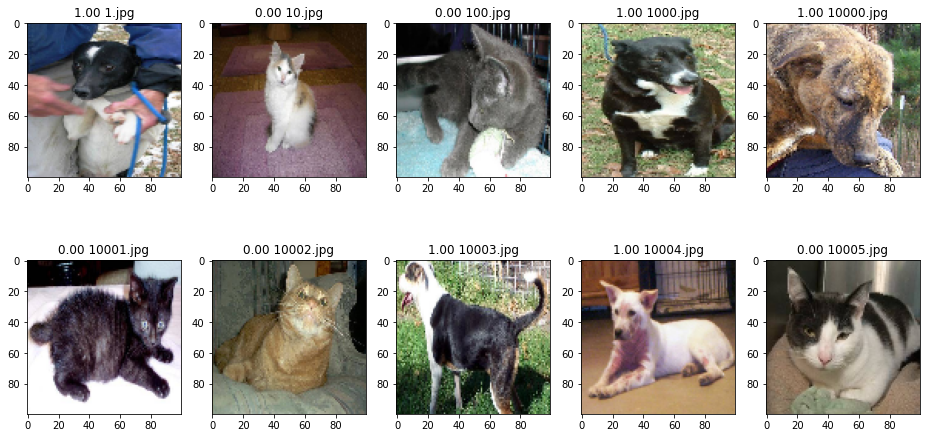

In [22]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [44]:
# test_pred.shape
# test_pred[:1]

array([[1.]], dtype=float32)

In [55]:
# Create file for submitting on Kaggle

import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 2.86579

## let's try too add level with relu activation

In [48]:
# Modification of network by dense layer as last layer 
# let's try too ad level with relu activation

# weigth of pre-trained network
for layer in base_model.layers:
    layer.trainable = False

#      Adding dense layer after 5thlayer
x = base_model.layers[-5].output
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0
                          activation='relu',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0
                          activation='sigmoid',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [49]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)      

In [50]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # binary_crossentropy log loss function
              metrics=['accuracy'])

In [52]:
#  Crease validation part
val_samples = 3  

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  

model.fit(train_data,
          steps_per_epoch=10,  # number of calling in epoch
          epochs=10,  # number of epoch for training
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 5s 538ms/step - loss: 0.7080 - accuracy: 0.4469 - val_loss: 0.6930 - val_accuracy: 0.6667
Epoch 2/10
10/10 [==============================] - 5s 507ms/step - loss: 0.9715 - accuracy: 0.4625 - val_loss: 0.6934 - val_accuracy: 0.6667
Epoch 3/10
10/10 [==============================] - 5s 504ms/step - loss: 0.6940 - accuracy: 0.5063 - val_loss: 0.6936 - val_accuracy: 0.6667
Epoch 4/10
10/10 [==============================] - 6s 572ms/step - loss: 0.7680 - accuracy: 0.4875 - val_loss: 0.6938 - val_accuracy: 0.6667
Epoch 5/10
10/10 [==============================] - 5s 544ms/step - loss: 0.8024 - accuracy: 0.4406 - val_loss: 0.6943 - val_accuracy: 0.6667
Epoch 6/10
10/10 [==============================] - 5s 506ms/step - loss: 0.7233 - accuracy: 0.5406 - val_loss: 0.6945 - val_accuracy: 0.6667
Epoch 7/10
10/10 [==============================] - 5s 539ms/step - loss: 0.6917 - accuracy: 0.4906 - val_loss: 0.6943 - val_accuracy: 0.6667
Epoch 

In [53]:
# PREDICTION on test data
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 328s 26ms/step


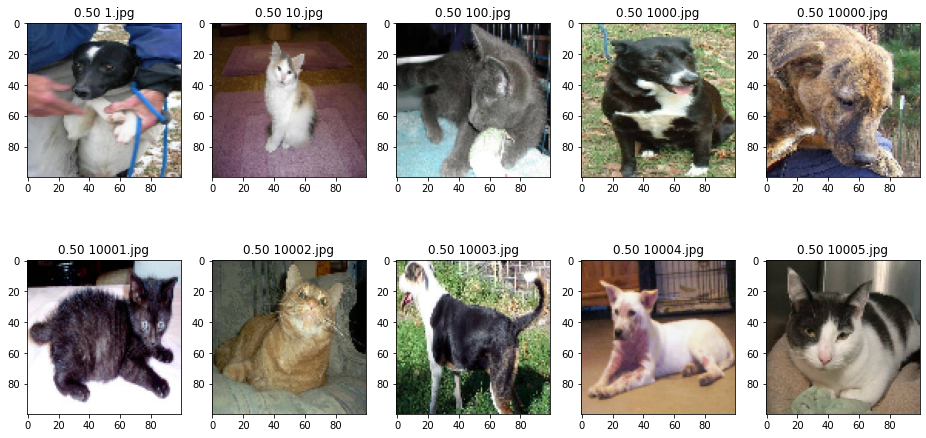

In [54]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [ ]:
# LogLoss = 0.73923

## let's try too add level with 2 extra relu activation

In [56]:
# Modification of network by dense layer as last layer +2 extra layer with RELU activation

# weigth of pre-trained network
for layer in base_model.layers:
    layer.trainable = False

#      Adding dense layer after 5thlayer
x = base_model.layers[-5].output
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0, so here id `
                          activation='relu',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0, so here id `
                          activation='relu',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # due to binary classification it's only two class exsistion and whether 1 or 0, so here id `
                          activation='sigmoid',  # activation function 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [57]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)      

In [58]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # binary_crossentropy log loss function
              metrics=['accuracy'])

In [59]:
#  Crease validation part
val_samples = 3  

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  

model.fit(train_data,
          steps_per_epoch=10,  # number of calling in epoch
          epochs=10,  # number of epoch for training
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 6s 525ms/step - loss: 5.3128 - accuracy: 0.5406 - val_loss: 3.6222 - val_accuracy: 0.3333
Epoch 2/10
10/10 [==============================] - 5s 537ms/step - loss: 1.2452 - accuracy: 0.5656 - val_loss: 1.1353 - val_accuracy: 0.3333
Epoch 3/10
10/10 [==============================] - 5s 517ms/step - loss: 0.7795 - accuracy: 0.4906 - val_loss: 0.6943 - val_accuracy: 0.6667
Epoch 4/10
10/10 [==============================] - 5s 507ms/step - loss: 0.8744 - accuracy: 0.4719 - val_loss: 0.6943 - val_accuracy: 0.6667
Epoch 5/10
10/10 [==============================] - 5s 536ms/step - loss: 0.7414 - accuracy: 0.4781 - val_loss: 0.6945 - val_accuracy: 0.6667
Epoch 6/10
10/10 [==============================] - 5s 526ms/step - loss: 0.6945 - accuracy: 0.5344 - val_loss: 0.6943 - val_accuracy: 0.6667
Epoch 7/10
10/10 [==============================] - 5s 508ms/step - loss: 0.6890 - accuracy: 0.4812 - val_loss: 0.6944 - val_accuracy: 0.6667
Epoch 

In [60]:
# PREDICTION on test data
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 315s 25ms/step


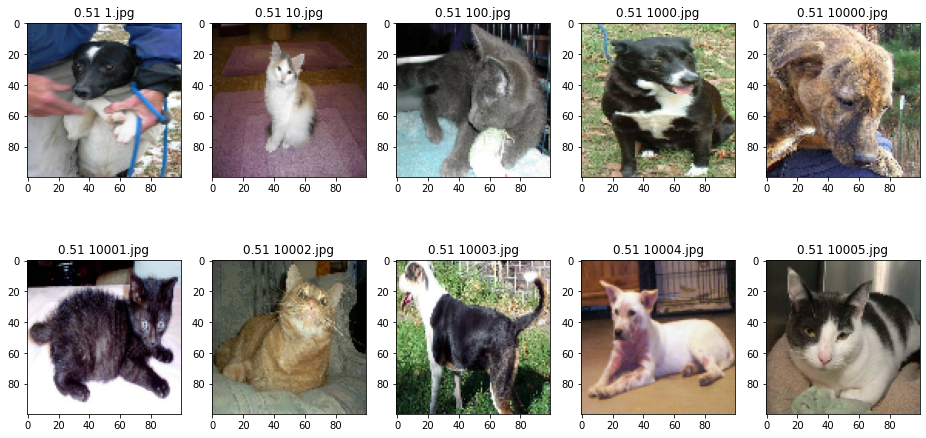

In [61]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [62]:
# Create file for submitting on Kaggle

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 0.70080